<a href="https://colab.research.google.com/github/ThisDavidAdams/MMR-summarization/blob/main/MMR_Summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone WCEP Repository and install dependencies


In [1]:
!git clone https://github.com/gandharvsuri/wcep-mds-dataset
%cd wcep-mds-dataset

Cloning into 'wcep-mds-dataset'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 125 (delta 65), reused 89 (delta 37), pack-reused 0
Receiving objects: 100% (125/125), 1.09 MiB | 5.34 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/wcep-mds-dataset


In [2]:
!pip install -r experiments/requirements.txt
!python -m nltk.downloader punkt

     |████████████████████████████████| 6.8MB 5.1MB/s 
     |████████████████████████████████| 1.6MB 39.5MB/s 
     |████████████████████████████████| 1.4MB 41.9MB/s 
  Cloning git://github.com/clic-lab/newsroom.git to /tmp/pip-install-bqb2nt88/newsroom
  Running command git clone -q git://github.com/clic-lab/newsroom.git /tmp/pip-install-bqb2nt88/newsroom
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 184kB 41.8MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434695 sha256=03fc946be1062f510bf9b9e3b2218231f084e4598d8fa1d67f5bff34da20ea96
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
  Created wheel for newsroom: filename=newsroom-0.1-cp37-none-any.whl size=281701 sha256=ff73f40488b057deb63b56d7efdc89ed7aa6c5cdace4c3d95b3f4c51d93de515
  Stored in directory: /tmp/pip-ephem-wheel-cache-qu2j33uo/wheels/d5/c4/c7/23cd619d0c4202ef81a4509bfbaa6d90d89200c3ee15e518

## Download the test dataset

WCEP-100

In [3]:
!mkdir WCEP
!gdown https://drive.google.com/uc?id=1qsd5pOCpeSXsaqNobXCrcAzhcjtG1wA1 -O WCEP/test.jsonl.gz

Downloading...
From: https://drive.google.com/uc?id=1qsd5pOCpeSXsaqNobXCrcAzhcjtG1wA1
To: /content/wcep-mds-dataset/WCEP/test.jsonl.gz
51.5MB [00:00, 141MB/s] 


In [4]:
import experiments.utils as utils

test_data = list(utils.read_jsonl_gz('WCEP/test.jsonl.gz'))
partial_test_data = test_data[:50] # for experimenting
print("Number of clusters:",len(test_data))
print(test_data[0].keys())

Number of clusters: 1022
dict_keys(['id', 'date', 'reference_urls', 'articles', 'summary', 'wiki_links', 'category'])


In [5]:
# summary_max = 0
# article_max = 0
# for c in test_data:
#   summary_max = max(summary_max,len(c['summary'].split(" ")))

#   for a in c['articles']:
#     if article_max < len(a['text'].split(" ")):
#       text = a["text"]
#     article_max = max(article_max,len(a['text'].split(" ")))

In [6]:
from statistics import mean

article_word_count = [len(a['text'].split()) for c in test_data for a in c["articles"]]
summary_word_count = [len(c['summary'].split()) for c in test_data]

print("max word count of articles:",max(article_word_count))
print("max word count of summary:",max(summary_word_count))
print("avg word count of articles:", int(mean(article_word_count)))
print("avg word count of summary:", int(mean(summary_word_count)))

max word count of articles: 13736
max word count of summary: 119
avg word count of articles: 403
avg word count of summary: 31


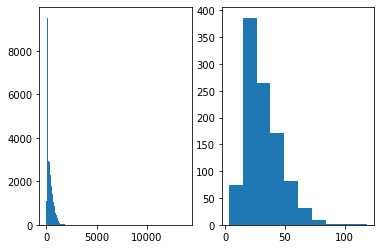

In [7]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)  
plt.hist(article_word_count, bins = 500)
plt.subplot(1, 2, 2)  
plt.hist(summary_word_count)
plt.show()

In [8]:
max_summary_length = 100
min_summary_length = 20

## Importing the pretrained models

In [9]:
!pip install torch
!pip install transformers
!pip install sentencepiece
!pip install spacy
!pip install bert-extractive-summarizer

     |████████████████████████████████| 2.3MB 6.7MB/s 
     |████████████████████████████████| 3.3MB 20.7MB/s 
     |████████████████████████████████| 901kB 35.3MB/s 
     |████████████████████████████████| 1.2MB 5.1MB/s 


In [10]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051304 sha256=b3f4a25100eea0bec9b55d7580e8e8ca6d08fe555bc1f340f00d5a8f478a5ba4
  Stored in directory: /tmp/pip-ephem-wheel-cache-yceq1lnm/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [11]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [12]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
# PEGASUS

from transformers import PegasusForConditionalGeneration, PegasusTokenizer

class Pegasus():

  def __init__(self,device):
    self.name = "Pegasus"
    self.model_name = "google/pegasus-xsum"
    self.tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    self.device = device
    self.model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum").to(device)
  
  def summarise(self, text):
    inputs = self.tokenizer([text], max_length=512, truncation = True, return_tensors='pt')
    inputs.to(self.device)
    translated = self.model.generate(inputs['input_ids'],
                                        min_length=min_summary_length,
                                        max_length=max_summary_length,
                                        temperature=0.7,
                                        early_stopping=True,
                                        top_k = 50
                                    )
    
    summary = self.tokenizer.batch_decode(translated, skip_special_tokens=True)

    return summary[0]



In [26]:
# T5

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

class T5():
  
  def __init__(self,device):
    self.name = "T5"
    self.device = device
    self.model = T5ForConditionalGeneration.from_pretrained('t5-large').to(device)
    self.tokenizer = T5Tokenizer.from_pretrained('t5-large')

  def summarise(self, text):
    text = "summarize: " + text
    tokenized_text = self.tokenizer.encode(text, return_tensors="pt", truncation = True).to(self.device)

    summary_ids = self.model.generate(tokenized_text,
                                        min_length=min_summary_length,
                                        max_length=max_summary_length,
                                        temperature=0.7,
                                        early_stopping=True,
                                        top_k = 50
                                      )
    
    summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary


In [27]:
# GPT2

from transformers import GPT2Tokenizer, GPT2LMHeadModel

class GPT2():

  def __init__(self,device):
    self.name = "GPT2"
    self.device = device
    self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device)
    self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 920)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids, 
                                      min_length = len(input_ids[0]) + min_summary_length,
                                      max_length=len(input_ids[0]) + max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50
                                    )
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    
    summary = output.split("TL;DR:")[-1]
    return summary

In [28]:
# XLNet

from transformers import XLNetTokenizer, XLNetLMHeadModel

class XLNet():
  
  def __init__(self,device):
    self.name = "XLNet"
    self.device = device
    self.tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
    self.model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased').to(device)

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 920)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids,
                                      min_length=len(input_ids[0]) + min_summary_length,
                                      max_length=len(input_ids[0]) + max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50
                                )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    output = output.split("TL;DR:")[-1]
    return output
  

In [29]:
# ProphetNet

from transformers import ProphetNetTokenizer, ProphetNetForConditionalGeneration

class ProphetNet():

  def __init__(self,device):
    self.name = "ProphetNet"
    self.device = device
    self.tokenizer = ProphetNetTokenizer.from_pretrained('microsoft/prophetnet-large-uncased')
    self.model = ProphetNetForConditionalGeneration.from_pretrained('microsoft/prophetnet-large-uncased').to(self.device)

  def summarise(self,text):
    input_ids = self.tokenizer(text, return_tensors="pt", truncation = True).input_ids
    decoder_input_ids = self.tokenizer("To summarise", return_tensors="pt").input_ids  
    input_ids = input_ids.to(self.device)
    decoder_input_ids = decoder_input_ids.to(self.device)

    beam_output = self.model.generate(input_ids, 
                                      decoder_input_ids = decoder_input_ids,
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50
                                )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    return output

In [30]:
# BART

from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

class BART():

  def __init__(self,device):
    self.name = "BART"
    self.device = device
    self.model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
    self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation = True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50
                                    )
    
    return ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

In [31]:
# LED

from transformers import LEDTokenizer, LEDForConditionalGeneration, LEDConfig

class LED():

  def __init__(self,device):
    self.name = "LED"
    self.device = device
    self.model = LEDForConditionalGeneration.from_pretrained('allenai/led-base-16384').to(self.device)
    self.tokenizer = LEDTokenizer.from_pretrained('allenai/led-base-16384')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation=True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50
                                    )
    return ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

In [33]:
prophetnet = ProphetNet(device)
gpt2 = GPT2(device)
xlnet = XLNet(device)
t5 = T5(device)
led = LED(device)
bart = BART(device)
pegasus = Pegasus(device)

In [35]:
SDS_models = {
      "ProphetNet" : prophetnet,
      "GPT2" : gpt2,
      "T5" : t5,
      "XLNet" : xlnet,
      "LED" : led,
      "BART" : bart,
      "Pegasus" : pegasus
}

In [36]:
# from transformers import *

# # Load model, model config and tokenizer via Transformers
# custom_config = AutoConfig.from_pretrained('xlnet-large-cased')
# custom_config.output_hidden_states=True
# custom_tokenizer = AutoTokenizer.from_pretrained('xlnet-large-cased')
# custom_model = AutoModel.from_pretrained('xlnet-large-cased', config=custom_config)

# from summarizer import Summarizer

# model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

# print(model(a))


In [54]:
summary_results = {
      "ProphetNet" : [],
      "GPT2" : [],
      "T5" : [],
      "XLNet" : [],
      "LED" : [],
      "BART" : [],
      "Pegasus" : []
}

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import gc
from datetime import datetime
# Generating summaries

summaries = []
# summary keys : summary, type (MDS/SDS), index (None/article_index), model, clusterid, Rouge_score, MMR_reduced

for cluster in tqdm(partial_test_data):
  
  for _,model in SDS_models.items():
    for i,article in tqdm(enumerate(cluster['articles'])):
      #Clean up CUDA

      if i == 20:
        break
      gc.collect()
      torch.cuda.empty_cache()
      d = {}
      text = article["text"]
      if text == '':
        continue

      summary = model.summarise(text)
      
      d["type"] = "SDS"
      d["model"] = model.name
      d["index"] = article["id"]
      d["clusterId"] = cluster["id"]

      text = None
      d["summary"] = summary

      rouge = evaluate([summary], [cluster["summary"]])
      summary = None
      d["rouge"] = rouge
      d["MMR_reduced"] = None
      summaries.append(d)
      summary_results[model.name].append(rouge)

      d = None
      rouge = None

# save the progress
now = datetime.now()
filename = "summaries" + str(now)+ ".jsonl"
print(filename)
utils.write_jsonl(summaries, filename)
utils.write_jsonl([], "/content/gdrive/MyDrive/ULETH/"+filename)

In [55]:
summaries = list(utils.read_jsonl(filename))

In [56]:
for d in summaries:
  summary_results[d["model"]].append(d["rouge"])

In [57]:
for model,scores in summary_results.items():
  r1 = []
  r2 = []
  rl = []

  for s in scores:
    r1.append(s["rouge-1"])
    r2.append(s["rouge-2"])
    rl.append(s["rouge-l"])
  
  r1p = mean([x['p'] for x in r1]) *100
  r1r = mean([x['r'] for x in r1]) *100
  r1f = mean([x['f'] for x in r1]) *100
  
  r2p = mean([x['p'] for x in r2]) *100
  r2r = mean([x['r'] for x in r2]) *100
  r2f = mean([x['f'] for x in r2]) *100
  
  rlp = mean([x['p'] for x in rl]) *100
  rlr = mean([x['r'] for x in rl]) *100
  rlf = mean([x['f'] for x in rl]) *100
  
  print(model)
  print("r1 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \n".format(r1p,r1r,r1f,r2p,r2r,r2p,rlp,rlr,rlf))
  
  

ProphetNet
r1 p: 19.184 r: 19.750 f: 18.159 
r2 p: 2.494 r: 2.718 f: 2.494 
r2 p: 13.809 r: 14.289 f: 13.076 

GPT2
r1 p: 16.217 r: 17.865 f: 15.855 
r2 p: 1.322 r: 1.463 f: 1.322 
r2 p: 11.555 r: 12.786 f: 11.331 

T5
r1 p: 29.465 r: 21.734 f: 23.913 
r2 p: 6.192 r: 5.235 f: 6.192 
r2 p: 20.978 r: 15.575 f: 17.042 

XLNet
r1 p: 23.375 r: 15.391 f: 17.640 
r2 p: 1.876 r: 1.337 f: 1.876 
r2 p: 15.491 r: 10.076 f: 11.532 

LED
r1 p: 39.452 r: 25.665 f: 29.879 
r2 p: 13.440 r: 8.325 f: 13.440 
r2 p: 27.766 r: 17.895 f: 20.931 

BART
r1 p: 34.079 r: 27.677 f: 29.120 
r2 p: 10.812 r: 8.850 f: 10.812 
r2 p: 23.986 r: 19.477 f: 20.470 

Pegasus
r1 p: 31.004 r: 34.680 f: 31.393 
r2 p: 11.673 r: 12.455 f: 11.673 
r2 p: 23.884 r: 26.703 f: 24.189 



## Setting up LDAMallet

In [ ]:
!pip install --upgrade gensim

In [ ]:
# install JAVA

import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
# Install Mallet

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

## Compute MMR

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def maximal_marginal_relevance(sentence_vector, phrases, embedding_matrix, lambda_constant=0.5, threshold_terms=10):
    """
    Return ranked phrases using MMR. Cosine similarity is used as similarity measure.
    :param sentence_vector: Query vector
    :param phrases: list of candidate phrases
    :param embedding_matrix: matrix having index as phrases and values as vector
    :param lambda_constant: 0.5 to balance diversity and accuracy. if lambda_constant is high, then higher accuracy. If lambda_constant is low then high diversity.
    :param threshold_terms: number of terms to include in result set
    :return: Ranked phrases with score
    """
    # todo: Use cosine similarity matrix for lookup among phrases instead of making call everytime.
    s = []
    r = sorted(phrases, key=lambda x: x[1], reverse=True)
    r = [i[0] for i in r]
    while len(r) > 0:
        score = 0
        phrase_to_add = ''
        for i in r:
            first_part = cosine_similarity([sentence_vector], [embedding_matrix.loc[i]])[0][0]
            second_part = 0
            for j in s:
                cos_sim = cosine_similarity([embedding_matrix.loc[i]], [embedding_matrix.loc[j[0]]])[0][0]
                if cos_sim > second_part:
                    second_part = cos_sim
            equation_score = lambda_constant*(first_part)-(1-lambda_constant) * second_part
            if equation_score > score:
                score = equation_score
                phrase_to_add = i
        if phrase_to_add == '':
            phrase_to_add = i
        r.remove(phrase_to_add)
        s.append((phrase_to_add, score))
    return (s, s[:threshold_terms])[threshold_terms > len(s)]

## Generate Summaries

In [ ]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import pickle

# Generating summaries

summaries = []
# summary keys : summary, type (MDS/SDS), index (None/article_index), model, clusterid, Rouge_score, MMR_reduced

for cluster in tqdm(test_data):

  # MDS
  for model in MDS_models:
    d = {}

    d["type"] = "MDS"
    d["model"] = model
    d["index"] = None
    d["clusterId"] = clusterId

    summary = MDS_models[model](cluster['articles'])
    d["summary"] = summary

    d["rouge"] = evaluate([summary], [cluster["summary"]])
    d["MMR_reduced"] = None
    summaries.append(d)
  
  # SDS
  for model in SDS_models:
    for article in cluster['articles']:
      d = {}

      d["type"] = "SDS"
      d["model"] = model
      d["index"] = article["id"]
      d["clusterId"] = clusterId

      summary = SDS_models[model](article)
      d["summary"] = summary

      d["rouge"] = evaluate([summary], [cluster["summary"]])
      d["MMR_reduced"] = None
      summaries.append(d)

# save the progress
utils.write_jsonl(summaries, "summaries.jsonl")

In [ ]:
summaries = list(utils.read_jsonl("summaries.jsonl"))

## MMR

In [ ]:
import experiments.sent_splitter as sent_splitter

sentSplitter = sent_splitter.SentenceSplitter()

# MMR 1
for summ in summaries:

  text = summ["summary"]
  sentences = sentSplitter(text)

  # MMR
  output = None # MMR ranked - least diverse
  summ["MMR_reduced"] = output

# save the progress
utils.write_jsonl(summaries, "summaries.jsonl")

In [ ]:
summaries = list(utils.read_jsonl("summaries.jsonl"))

clusters = [c["clusterId"] for c in summaries]
clusters = list(set(clusters))

## Final Summaries

In [ ]:
# Generating final summary
# MMR 2

final_summaries = []

for cid in clusters:
  d = {}
  d["clusterId"] = cid

  cluster_summaries = [c for c in summaries if cid = c["clusterId"]]
  ground_truth = [c["summary"] for c in test_data where c["id"] == cid][0]

  cluster_sentences = []
  for summ in cluster_summaries:

    text = summ["MMR_reduced"]
    sentences = sentSplitter(text)

    cluster_sentences.extend(sentences)


  # MMR 

  # pick top n sentences
  final_summary = ' '.join(topn_sentences)
  Rouge_score = evaluate([final_summary], [ground_truth])

  d["summary"] = final_summary
  d["rouge"] = Rouge_score


  final_summaries.append(d)

# save the progress  
utils.write_jsonl(final_summaries, "finalsummaries.jsonl")